In [89]:
class HoltWinters:
    def __init__(self, train_data, season_len, alpha, beta, gamma, n_preds):
        self.train_data = train_data
        self.season_len = season_len
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds

    def initial_trend(self):
        sum = 0.0
        for i in range(self.season_len):
            sum += float(self.train_data[i+self.season_len] - self.train_data[i]) / self.season_len
        return sum / self.season_len  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.train_data)/self.season_len)
        for j in range(n_seasons):
            season_averages.append(sum(self.train_data[self.season_len*j:self.season_len*j+self.season_len])/float(self.season_len))
        for i in range(self.season_len):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.train_data[self.season_len*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.train_data)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.train_data[0]
                trend = self.initial_trend()
                self.result.append(self.train_data[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.season_len])

                continue
            if i >= len(self.train_data): # прогнозируем
                m = i - len(self.train_data) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.season_len])

            else:
                val = self.train_data[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.season_len]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.season_len] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.season_len]
                self.result.append(smooth+trend+seasonals[i%self.season_len])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.season_len])

In [90]:
import pandas as pd

data = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])

In [91]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

def to_minimize(x):
    errors = []

    values = data.values
    alpha, beta, gamma = x

    tscv = TimeSeriesSplit(n_splits=3) 

    for train, test in tscv.split(values):

        model = HoltWinters(train_data=values[train], season_len = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [92]:
from scipy.optimize import minimize

x = [0, 0, 0]

opt = minimize(to_minimize, method="TNC", x0=x, bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.001990800133984838 3.148640184486018e-05 0.1958164647266124


In [93]:
test = data.values[-500:]
model = HoltWinters(train_data=data.values[:-500], season_len = 24*7, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_preds=len(test))
model.triple_exponential_smoothing()

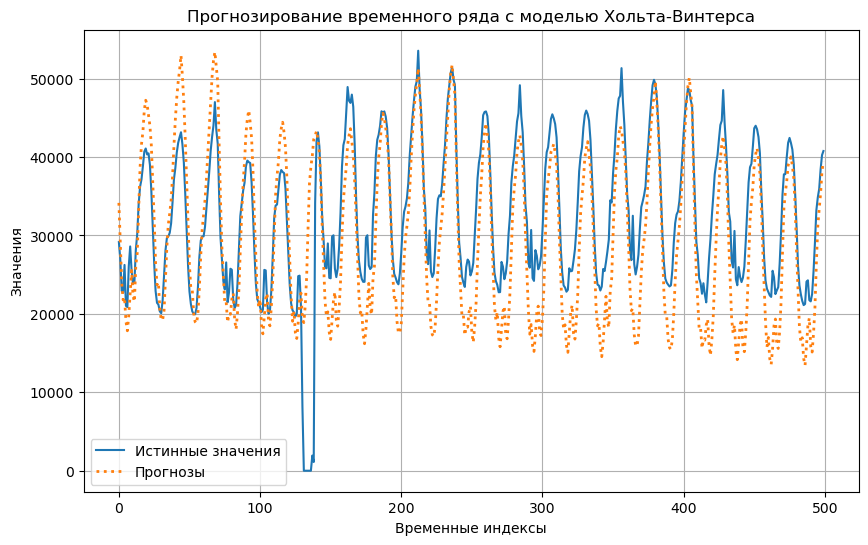

In [94]:
import matplotlib.pyplot as plt

true_values = data.values[-500:]


predictions = model.result[-500:]

# Создаем список индексов для оси времени (можете использовать даты, если они есть)
time_index = list(range(len(true_values)))

# Визуализация истинных значений и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(time_index, true_values, label='Истинные значения', linestyle='-')
plt.plot(time_index, predictions, label='Прогнозы', linewidth=2,linestyle=':')
plt.title('Прогнозирование временного ряда с моделью Хольта-Винтерса')
plt.xlabel('Временные индексы')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()
